In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import os
from tqdm.auto import tqdm
from glob import glob
import cv2
import numpy as np
import pandas as pd
import PIL 
import urllib
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from random import uniform
from imgaug import augmenters as iaa
import torch.utils.data as td
import torchvision as tv
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount._DEBUG = True
drive.mount('/content/drive', force_remount=True)

In [ ]:
os.chdir('./drive/MyDrive/hack/')

In [ ]:
%%time
!unzip "./data.zip" -d "/content/drive/MyDrive/hack/data/"

In [ ]:
transform = transforms.Compose([
                                transforms.ColorJitter(brightness=.3),
                                
                                transforms.RandomRotation(30),
                                transforms.RandomVerticalFlip(0.3),
                                transforms.RandomHorizontalFlip(0.3),
                                transforms.CenterCrop((256,256)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485 , 0.456, 0.406], [0.229, 0.224 , 0.225]),                                
                               ])

valid_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485 , 0.456, 0.406], [0.229, 0.224 , 0.225]), 
    ])

In [ ]:
train_dataset=datasets.ImageFolder('./data/train/',transform=transform)
valid_dataset=datasets.ImageFolder('./data/valid/',transform=valid_transforms)

In [ ]:
# prepare data loaders (combine dataset and sampler)
batch_size=64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    
device

'cuda'

In [ ]:
import torchvision.models as models

model=models.resnet101(pretrained=True)
# model = models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
num_classes = 5
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min')

In [ ]:
# number of epochs to train the model
n_epochs = 200

valid_loss_min = np.Inf # track change in validation loss

# keep track of training and validation loss
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

train_acc = torch.zeros(n_epochs)
valid_acc = torch.zeros(n_epochs)
model.to(device)

for e in range(0, n_epochs):

   
    ###################
    # train the model #
    ###################
    model.train()
    for data, labels in tqdm(train_dataloader):
        # move tensors to GPU if CUDA is available
        data, labels = data.to(device), labels.to(device)
        # clear the gradients of all optimized variables
        
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model(data)
        # calculate the batch loss
        loss = criterion(logits, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[e] += loss.item()
        
        ps = F.softmax(logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.reshape(top_class.shape)
        train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    
    train_loss[e] /= len(train_dataloader)
    train_acc[e] /= len(train_dataloader)
        
        
    ######################    
    # validate the model #
    ######################
    with torch.no_grad(): 
        model.eval()
        for data, labels in tqdm(valid_dataloader):
            # move tensors to GPU if CUDA is available
            data, labels = data.to(device), labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model(data)
            # calculate the batch loss
            loss = criterion(logits, labels)
            # update average validation loss 
            valid_loss[e] += loss.item()
            
            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.reshape(top_class.shape)
            valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
            
    
    # calculate average losses
    valid_loss[e] /= len(valid_dataloader)
    valid_acc[e] /= len(valid_dataloader)
    
    scheduler.step(valid_loss[e])    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss[e], valid_loss[e]))
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(
        e, train_acc[e], valid_acc[e]))
    
    # save model if validation loss has decreased
    if valid_loss[e] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[e]))
        torch.save(model.state_dict(), 'hackaton.pt')
        valid_loss_min = valid_loss[e]

  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 0 	Training Loss: 0.036874 	Validation Loss: 0.029675
Epoch: 0 	Training accuracy: 0.987519 	Validation accuracy: 0.994141
Validation loss decreased (inf --> 0.029675).  Saving model ...


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.028575 	Validation Loss: 0.041976
Epoch: 1 	Training accuracy: 0.992078 	Validation accuracy: 0.986328


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.014937 	Validation Loss: 0.033600
Epoch: 2 	Training accuracy: 0.995651 	Validation accuracy: 0.993164


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.019317 	Validation Loss: 0.041856
Epoch: 3 	Training accuracy: 0.994114 	Validation accuracy: 0.993164


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.019972 	Validation Loss: 0.027063
Epoch: 4 	Training accuracy: 0.993904 	Validation accuracy: 0.992188
Validation loss decreased (0.029675 --> 0.027063).  Saving model ...


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.016998 	Validation Loss: 0.059831
Epoch: 5 	Training accuracy: 0.994535 	Validation accuracy: 0.983398


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.013779 	Validation Loss: 0.031823
Epoch: 6 	Training accuracy: 0.996142 	Validation accuracy: 0.992188


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.007955 	Validation Loss: 0.033915
Epoch: 7 	Training accuracy: 0.997688 	Validation accuracy: 0.990234


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.011816 	Validation Loss: 0.045761
Epoch: 8 	Training accuracy: 0.996286 	Validation accuracy: 0.986328


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.011382 	Validation Loss: 0.028585
Epoch: 9 	Training accuracy: 0.996917 	Validation accuracy: 0.994001


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.016605 	Validation Loss: 0.018722
Epoch: 10 	Training accuracy: 0.995165 	Validation accuracy: 0.994141
Validation loss decreased (0.027063 --> 0.018722).  Saving model ...


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.011806 	Validation Loss: 0.030326
Epoch: 11 	Training accuracy: 0.996637 	Validation accuracy: 0.994001


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.008798 	Validation Loss: 0.026031
Epoch: 12 	Training accuracy: 0.997123 	Validation accuracy: 0.994838


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.009420 	Validation Loss: 0.032343
Epoch: 13 	Training accuracy: 0.997407 	Validation accuracy: 0.993164


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.008921 	Validation Loss: 0.030460
Epoch: 14 	Training accuracy: 0.997407 	Validation accuracy: 0.991211


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.008838 	Validation Loss: 0.076276
Epoch: 15 	Training accuracy: 0.997337 	Validation accuracy: 0.981306


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.011277 	Validation Loss: 0.061565
Epoch: 16 	Training accuracy: 0.996427 	Validation accuracy: 0.985352


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.014376 	Validation Loss: 0.047320
Epoch: 17 	Training accuracy: 0.995726 	Validation accuracy: 0.991071


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.016120 	Validation Loss: 0.037869
Epoch: 18 	Training accuracy: 0.995516 	Validation accuracy: 0.989118


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.009528 	Validation Loss: 0.034349
Epoch: 19 	Training accuracy: 0.996567 	Validation accuracy: 0.991211


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.007475 	Validation Loss: 0.032362
Epoch: 20 	Training accuracy: 0.997898 	Validation accuracy: 0.992048


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.005633 	Validation Loss: 0.024481
Epoch: 21 	Training accuracy: 0.998178 	Validation accuracy: 0.993025


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.003644 	Validation Loss: 0.017725
Epoch: 22 	Training accuracy: 0.998734 	Validation accuracy: 0.995117
Validation loss decreased (0.018722 --> 0.017725).  Saving model ...


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.001504 	Validation Loss: 0.017879
Epoch: 23 	Training accuracy: 0.999580 	Validation accuracy: 0.994141


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.000985 	Validation Loss: 0.017474
Epoch: 24 	Training accuracy: 0.999860 	Validation accuracy: 0.995117
Validation loss decreased (0.017725 --> 0.017474).  Saving model ...


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.000950 	Validation Loss: 0.018539
Epoch: 25 	Training accuracy: 0.999790 	Validation accuracy: 0.994141


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.000646 	Validation Loss: 0.016992
Epoch: 26 	Training accuracy: 0.999930 	Validation accuracy: 0.996094
Validation loss decreased (0.017474 --> 0.016992).  Saving model ...


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 0.000707 	Validation Loss: 0.015629
Epoch: 27 	Training accuracy: 0.999790 	Validation accuracy: 0.997070
Validation loss decreased (0.016992 --> 0.015629).  Saving model ...


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 0.000562 	Validation Loss: 0.015574
Epoch: 28 	Training accuracy: 0.999860 	Validation accuracy: 0.997070
Validation loss decreased (0.015629 --> 0.015574).  Saving model ...


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.000466 	Validation Loss: 0.015462
Epoch: 29 	Training accuracy: 0.999930 	Validation accuracy: 0.999023
Validation loss decreased (0.015574 --> 0.015462).  Saving model ...


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.000361 	Validation Loss: 0.015522
Epoch: 30 	Training accuracy: 1.000000 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 31 	Training Loss: 0.000394 	Validation Loss: 0.016992
Epoch: 31 	Training accuracy: 1.000000 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 32 	Training Loss: 0.000297 	Validation Loss: 0.016979
Epoch: 32 	Training accuracy: 0.999930 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 33 	Training Loss: 0.000436 	Validation Loss: 0.015533
Epoch: 33 	Training accuracy: 0.999860 	Validation accuracy: 0.998047


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 34 	Training Loss: 0.000512 	Validation Loss: 0.015781
Epoch: 34 	Training accuracy: 0.999860 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 35 	Training Loss: 0.000346 	Validation Loss: 0.016542
Epoch: 35 	Training accuracy: 0.999930 	Validation accuracy: 0.996931


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 36 	Training Loss: 0.000296 	Validation Loss: 0.016089
Epoch: 36 	Training accuracy: 0.999930 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 37 	Training Loss: 0.000112 	Validation Loss: 0.016328
Epoch: 37 	Training accuracy: 1.000000 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 38 	Training Loss: 0.000183 	Validation Loss: 0.019155
Epoch: 38 	Training accuracy: 1.000000 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 39 	Training Loss: 0.000137 	Validation Loss: 0.016987
Epoch: 39 	Training accuracy: 1.000000 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 40 	Training Loss: 0.000161 	Validation Loss: 0.017105
Epoch: 40 	Training accuracy: 1.000000 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 41 	Training Loss: 0.000221 	Validation Loss: 0.019039
Epoch: 41 	Training accuracy: 0.999930 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 42 	Training Loss: 0.000116 	Validation Loss: 0.017616
Epoch: 42 	Training accuracy: 1.000000 	Validation accuracy: 0.998047


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 43 	Training Loss: 0.000096 	Validation Loss: 0.016710
Epoch: 43 	Training accuracy: 1.000000 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 44 	Training Loss: 0.000220 	Validation Loss: 0.018643
Epoch: 44 	Training accuracy: 0.999930 	Validation accuracy: 0.994838


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 45 	Training Loss: 0.000206 	Validation Loss: 0.017212
Epoch: 45 	Training accuracy: 0.999930 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 46 	Training Loss: 0.000161 	Validation Loss: 0.017672
Epoch: 46 	Training accuracy: 0.999930 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 47 	Training Loss: 0.000154 	Validation Loss: 0.017244
Epoch: 47 	Training accuracy: 1.000000 	Validation accuracy: 0.998047


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 48 	Training Loss: 0.000281 	Validation Loss: 0.018406
Epoch: 48 	Training accuracy: 0.999930 	Validation accuracy: 0.994978


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 49 	Training Loss: 0.000383 	Validation Loss: 0.017733
Epoch: 49 	Training accuracy: 0.999930 	Validation accuracy: 0.996931


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 50 	Training Loss: 0.000183 	Validation Loss: 0.017902
Epoch: 50 	Training accuracy: 0.999930 	Validation accuracy: 0.998047


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 51 	Training Loss: 0.000088 	Validation Loss: 0.017963
Epoch: 51 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 52 	Training Loss: 0.000079 	Validation Loss: 0.020186
Epoch: 52 	Training accuracy: 1.000000 	Validation accuracy: 0.994978


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 53 	Training Loss: 0.000182 	Validation Loss: 0.017508
Epoch: 53 	Training accuracy: 0.999930 	Validation accuracy: 0.998047


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 54 	Training Loss: 0.000333 	Validation Loss: 0.018361
Epoch: 54 	Training accuracy: 0.999860 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 55 	Training Loss: 0.000061 	Validation Loss: 0.018313
Epoch: 55 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 56 	Training Loss: 0.000188 	Validation Loss: 0.017854
Epoch: 56 	Training accuracy: 0.999930 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 57 	Training Loss: 0.000189 	Validation Loss: 0.018067
Epoch: 57 	Training accuracy: 0.999930 	Validation accuracy: 0.994978


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 58 	Training Loss: 0.000095 	Validation Loss: 0.017622
Epoch: 58 	Training accuracy: 1.000000 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 59 	Training Loss: 0.000085 	Validation Loss: 0.018241
Epoch: 59 	Training accuracy: 1.000000 	Validation accuracy: 0.998047


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 60 	Training Loss: 0.000196 	Validation Loss: 0.017238
Epoch: 60 	Training accuracy: 0.999930 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 61 	Training Loss: 0.000067 	Validation Loss: 0.018331
Epoch: 61 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 62 	Training Loss: 0.000094 	Validation Loss: 0.017123
Epoch: 62 	Training accuracy: 1.000000 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 63 	Training Loss: 0.000137 	Validation Loss: 0.017777
Epoch: 63 	Training accuracy: 0.999930 	Validation accuracy: 0.998047


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 64 	Training Loss: 0.000107 	Validation Loss: 0.018317
Epoch: 64 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 65 	Training Loss: 0.000183 	Validation Loss: 0.017950
Epoch: 65 	Training accuracy: 0.999930 	Validation accuracy: 0.998047


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 66 	Training Loss: 0.000112 	Validation Loss: 0.017201
Epoch: 66 	Training accuracy: 1.000000 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 67 	Training Loss: 0.000149 	Validation Loss: 0.017596
Epoch: 67 	Training accuracy: 1.000000 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 68 	Training Loss: 0.000090 	Validation Loss: 0.017468
Epoch: 68 	Training accuracy: 1.000000 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 69 	Training Loss: 0.000153 	Validation Loss: 0.017712
Epoch: 69 	Training accuracy: 1.000000 	Validation accuracy: 0.998047


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 70 	Training Loss: 0.000486 	Validation Loss: 0.019068
Epoch: 70 	Training accuracy: 0.999930 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 71 	Training Loss: 0.000119 	Validation Loss: 0.018113
Epoch: 71 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 72 	Training Loss: 0.000174 	Validation Loss: 0.017276
Epoch: 72 	Training accuracy: 0.999930 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 73 	Training Loss: 0.000101 	Validation Loss: 0.017810
Epoch: 73 	Training accuracy: 1.000000 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 74 	Training Loss: 0.000147 	Validation Loss: 0.016927
Epoch: 74 	Training accuracy: 0.999930 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 75 	Training Loss: 0.000183 	Validation Loss: 0.018038
Epoch: 75 	Training accuracy: 0.999930 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 76 	Training Loss: 0.000144 	Validation Loss: 0.017644
Epoch: 76 	Training accuracy: 1.000000 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 77 	Training Loss: 0.000429 	Validation Loss: 0.017612
Epoch: 77 	Training accuracy: 0.999930 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 78 	Training Loss: 0.000100 	Validation Loss: 0.017141
Epoch: 78 	Training accuracy: 1.000000 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 79 	Training Loss: 0.000122 	Validation Loss: 0.017664
Epoch: 79 	Training accuracy: 1.000000 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 80 	Training Loss: 0.000111 	Validation Loss: 0.017646
Epoch: 80 	Training accuracy: 1.000000 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 81 	Training Loss: 0.000100 	Validation Loss: 0.017909
Epoch: 81 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 82 	Training Loss: 0.000180 	Validation Loss: 0.019842
Epoch: 82 	Training accuracy: 0.999930 	Validation accuracy: 0.994838


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 83 	Training Loss: 0.000101 	Validation Loss: 0.017296
Epoch: 83 	Training accuracy: 1.000000 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 84 	Training Loss: 0.000120 	Validation Loss: 0.018251
Epoch: 84 	Training accuracy: 1.000000 	Validation accuracy: 0.996931


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 85 	Training Loss: 0.000089 	Validation Loss: 0.017689
Epoch: 85 	Training accuracy: 1.000000 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 86 	Training Loss: 0.000217 	Validation Loss: 0.019507
Epoch: 86 	Training accuracy: 0.999930 	Validation accuracy: 0.996931


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 87 	Training Loss: 0.000063 	Validation Loss: 0.017985
Epoch: 87 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 88 	Training Loss: 0.000128 	Validation Loss: 0.017794
Epoch: 88 	Training accuracy: 1.000000 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 89 	Training Loss: 0.000074 	Validation Loss: 0.017543
Epoch: 89 	Training accuracy: 1.000000 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 90 	Training Loss: 0.000150 	Validation Loss: 0.018193
Epoch: 90 	Training accuracy: 0.999930 	Validation accuracy: 0.995954


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 91 	Training Loss: 0.000085 	Validation Loss: 0.018417
Epoch: 91 	Training accuracy: 1.000000 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 92 	Training Loss: 0.000081 	Validation Loss: 0.019341
Epoch: 92 	Training accuracy: 1.000000 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 93 	Training Loss: 0.000579 	Validation Loss: 0.017861
Epoch: 93 	Training accuracy: 0.999860 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 94 	Training Loss: 0.000198 	Validation Loss: 0.017463
Epoch: 94 	Training accuracy: 0.999930 	Validation accuracy: 0.996931


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 95 	Training Loss: 0.000102 	Validation Loss: 0.018965
Epoch: 95 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 96 	Training Loss: 0.000352 	Validation Loss: 0.018164
Epoch: 96 	Training accuracy: 0.999860 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 97 	Training Loss: 0.000065 	Validation Loss: 0.017076
Epoch: 97 	Training accuracy: 1.000000 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 98 	Training Loss: 0.000133 	Validation Loss: 0.017781
Epoch: 98 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 99 	Training Loss: 0.000176 	Validation Loss: 0.017425
Epoch: 99 	Training accuracy: 0.999930 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 100 	Training Loss: 0.000067 	Validation Loss: 0.017237
Epoch: 100 	Training accuracy: 1.000000 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 101 	Training Loss: 0.000105 	Validation Loss: 0.017975
Epoch: 101 	Training accuracy: 1.000000 	Validation accuracy: 0.995954


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 102 	Training Loss: 0.000067 	Validation Loss: 0.017992
Epoch: 102 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 103 	Training Loss: 0.000094 	Validation Loss: 0.017523
Epoch: 103 	Training accuracy: 1.000000 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 104 	Training Loss: 0.000100 	Validation Loss: 0.017298
Epoch: 104 	Training accuracy: 1.000000 	Validation accuracy: 0.998047


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 105 	Training Loss: 0.000070 	Validation Loss: 0.017838
Epoch: 105 	Training accuracy: 1.000000 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 106 	Training Loss: 0.000161 	Validation Loss: 0.017529
Epoch: 106 	Training accuracy: 1.000000 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 107 	Training Loss: 0.000176 	Validation Loss: 0.017857
Epoch: 107 	Training accuracy: 0.999930 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 108 	Training Loss: 0.000097 	Validation Loss: 0.017282
Epoch: 108 	Training accuracy: 1.000000 	Validation accuracy: 0.998047


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 109 	Training Loss: 0.000084 	Validation Loss: 0.017217
Epoch: 109 	Training accuracy: 1.000000 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 110 	Training Loss: 0.000139 	Validation Loss: 0.018168
Epoch: 110 	Training accuracy: 1.000000 	Validation accuracy: 0.994978


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 111 	Training Loss: 0.000060 	Validation Loss: 0.017852
Epoch: 111 	Training accuracy: 1.000000 	Validation accuracy: 0.998047


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 112 	Training Loss: 0.000095 	Validation Loss: 0.018531
Epoch: 112 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 113 	Training Loss: 0.000093 	Validation Loss: 0.018398
Epoch: 113 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 114 	Training Loss: 0.000057 	Validation Loss: 0.018397
Epoch: 114 	Training accuracy: 1.000000 	Validation accuracy: 0.994978


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 115 	Training Loss: 0.000122 	Validation Loss: 0.017639
Epoch: 115 	Training accuracy: 1.000000 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 116 	Training Loss: 0.000116 	Validation Loss: 0.018320
Epoch: 116 	Training accuracy: 1.000000 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 117 	Training Loss: 0.000105 	Validation Loss: 0.017247
Epoch: 117 	Training accuracy: 1.000000 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 118 	Training Loss: 0.000144 	Validation Loss: 0.018144
Epoch: 118 	Training accuracy: 0.999930 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 119 	Training Loss: 0.000107 	Validation Loss: 0.017622
Epoch: 119 	Training accuracy: 1.000000 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 120 	Training Loss: 0.000071 	Validation Loss: 0.017415
Epoch: 120 	Training accuracy: 1.000000 	Validation accuracy: 0.996931


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 121 	Training Loss: 0.000067 	Validation Loss: 0.017578
Epoch: 121 	Training accuracy: 1.000000 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 122 	Training Loss: 0.000106 	Validation Loss: 0.017546
Epoch: 122 	Training accuracy: 1.000000 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 123 	Training Loss: 0.000086 	Validation Loss: 0.017476
Epoch: 123 	Training accuracy: 1.000000 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 124 	Training Loss: 0.000308 	Validation Loss: 0.017376
Epoch: 124 	Training accuracy: 0.999930 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 125 	Training Loss: 0.000095 	Validation Loss: 0.017671
Epoch: 125 	Training accuracy: 1.000000 	Validation accuracy: 0.998047


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 126 	Training Loss: 0.000130 	Validation Loss: 0.018444
Epoch: 126 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 127 	Training Loss: 0.000090 	Validation Loss: 0.017958
Epoch: 127 	Training accuracy: 1.000000 	Validation accuracy: 0.998047


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 128 	Training Loss: 0.000101 	Validation Loss: 0.018004
Epoch: 128 	Training accuracy: 1.000000 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 129 	Training Loss: 0.000211 	Validation Loss: 0.018089
Epoch: 129 	Training accuracy: 0.999930 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 130 	Training Loss: 0.000116 	Validation Loss: 0.018734
Epoch: 130 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 131 	Training Loss: 0.000078 	Validation Loss: 0.018916
Epoch: 131 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 132 	Training Loss: 0.000076 	Validation Loss: 0.017559
Epoch: 132 	Training accuracy: 1.000000 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 133 	Training Loss: 0.000141 	Validation Loss: 0.018756
Epoch: 133 	Training accuracy: 0.999930 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 134 	Training Loss: 0.000083 	Validation Loss: 0.017908
Epoch: 134 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 135 	Training Loss: 0.000128 	Validation Loss: 0.017286
Epoch: 135 	Training accuracy: 1.000000 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 136 	Training Loss: 0.000173 	Validation Loss: 0.017853
Epoch: 136 	Training accuracy: 1.000000 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 137 	Training Loss: 0.000205 	Validation Loss: 0.017962
Epoch: 137 	Training accuracy: 1.000000 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 138 	Training Loss: 0.000172 	Validation Loss: 0.018805
Epoch: 138 	Training accuracy: 0.999930 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 139 	Training Loss: 0.000111 	Validation Loss: 0.017891
Epoch: 139 	Training accuracy: 1.000000 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 140 	Training Loss: 0.000095 	Validation Loss: 0.017463
Epoch: 140 	Training accuracy: 1.000000 	Validation accuracy: 0.998047


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 141 	Training Loss: 0.000169 	Validation Loss: 0.017529
Epoch: 141 	Training accuracy: 1.000000 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 142 	Training Loss: 0.000141 	Validation Loss: 0.017765
Epoch: 142 	Training accuracy: 1.000000 	Validation accuracy: 0.998047


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 143 	Training Loss: 0.000073 	Validation Loss: 0.017545
Epoch: 143 	Training accuracy: 1.000000 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 144 	Training Loss: 0.000120 	Validation Loss: 0.018645
Epoch: 144 	Training accuracy: 1.000000 	Validation accuracy: 0.995954


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 145 	Training Loss: 0.000093 	Validation Loss: 0.018953
Epoch: 145 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 146 	Training Loss: 0.000206 	Validation Loss: 0.018163
Epoch: 146 	Training accuracy: 0.999930 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 147 	Training Loss: 0.000156 	Validation Loss: 0.017403
Epoch: 147 	Training accuracy: 0.999930 	Validation accuracy: 0.998047


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 148 	Training Loss: 0.000387 	Validation Loss: 0.019735
Epoch: 148 	Training accuracy: 0.999860 	Validation accuracy: 0.998884


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 149 	Training Loss: 0.000126 	Validation Loss: 0.017467
Epoch: 149 	Training accuracy: 1.000000 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 150 	Training Loss: 0.000268 	Validation Loss: 0.017791
Epoch: 150 	Training accuracy: 0.999860 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 151 	Training Loss: 0.000097 	Validation Loss: 0.017598
Epoch: 151 	Training accuracy: 1.000000 	Validation accuracy: 0.998047


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 152 	Training Loss: 0.000095 	Validation Loss: 0.017886
Epoch: 152 	Training accuracy: 1.000000 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 153 	Training Loss: 0.000069 	Validation Loss: 0.018183
Epoch: 153 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 154 	Training Loss: 0.000124 	Validation Loss: 0.017740
Epoch: 154 	Training accuracy: 1.000000 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 155 	Training Loss: 0.000172 	Validation Loss: 0.018570
Epoch: 155 	Training accuracy: 0.999930 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 156 	Training Loss: 0.000059 	Validation Loss: 0.017872
Epoch: 156 	Training accuracy: 1.000000 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 157 	Training Loss: 0.000066 	Validation Loss: 0.019851
Epoch: 157 	Training accuracy: 1.000000 	Validation accuracy: 0.996931


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 158 	Training Loss: 0.000082 	Validation Loss: 0.017957
Epoch: 158 	Training accuracy: 1.000000 	Validation accuracy: 0.998047


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 159 	Training Loss: 0.000077 	Validation Loss: 0.017798
Epoch: 159 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 160 	Training Loss: 0.000181 	Validation Loss: 0.018317
Epoch: 160 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 161 	Training Loss: 0.000079 	Validation Loss: 0.017700
Epoch: 161 	Training accuracy: 1.000000 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 162 	Training Loss: 0.000084 	Validation Loss: 0.018375
Epoch: 162 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 163 	Training Loss: 0.000113 	Validation Loss: 0.018438
Epoch: 163 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 164 	Training Loss: 0.000062 	Validation Loss: 0.016843
Epoch: 164 	Training accuracy: 1.000000 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 165 	Training Loss: 0.000133 	Validation Loss: 0.019441
Epoch: 165 	Training accuracy: 1.000000 	Validation accuracy: 0.994978


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 166 	Training Loss: 0.000131 	Validation Loss: 0.017275
Epoch: 166 	Training accuracy: 1.000000 	Validation accuracy: 0.998047


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 167 	Training Loss: 0.000105 	Validation Loss: 0.018406
Epoch: 167 	Training accuracy: 1.000000 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 168 	Training Loss: 0.000266 	Validation Loss: 0.017896
Epoch: 168 	Training accuracy: 0.999930 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 169 	Training Loss: 0.000064 	Validation Loss: 0.017991
Epoch: 169 	Training accuracy: 1.000000 	Validation accuracy: 0.995954


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 170 	Training Loss: 0.000097 	Validation Loss: 0.017677
Epoch: 170 	Training accuracy: 1.000000 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 171 	Training Loss: 0.000140 	Validation Loss: 0.017817
Epoch: 171 	Training accuracy: 1.000000 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 172 	Training Loss: 0.000370 	Validation Loss: 0.018253
Epoch: 172 	Training accuracy: 0.999860 	Validation accuracy: 0.995117


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 173 	Training Loss: 0.000071 	Validation Loss: 0.017172
Epoch: 173 	Training accuracy: 1.000000 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 174 	Training Loss: 0.000081 	Validation Loss: 0.018026
Epoch: 174 	Training accuracy: 1.000000 	Validation accuracy: 0.994978


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 175 	Training Loss: 0.000074 	Validation Loss: 0.017071
Epoch: 175 	Training accuracy: 1.000000 	Validation accuracy: 0.999023


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 176 	Training Loss: 0.000111 	Validation Loss: 0.018369
Epoch: 176 	Training accuracy: 1.000000 	Validation accuracy: 0.994978


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 177 	Training Loss: 0.000089 	Validation Loss: 0.018385
Epoch: 177 	Training accuracy: 1.000000 	Validation accuracy: 0.996094


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 178 	Training Loss: 0.000158 	Validation Loss: 0.017278
Epoch: 178 	Training accuracy: 0.999930 	Validation accuracy: 0.997070


  0%|          | 0/223 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 179 	Training Loss: 0.000171 	Validation Loss: 0.018236
Epoch: 179 	Training accuracy: 1.000000 	Validation accuracy: 0.996931


  0%|          | 0/223 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

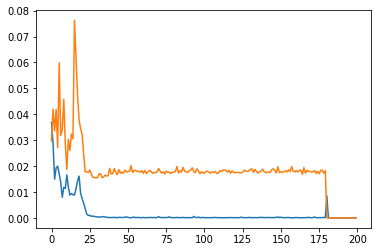

In [ ]:
plt.plot(train_loss)
plt.plot(valid_loss)

In [ ]:
test_transform = transforms.Compose([transforms.Resize((256,256)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485 , 0.456, 0.406], [0.229, 0.224 , 0.225])
                                    ])

In [ ]:
test_dataset=datasets.ImageFolder('./test/',transform=test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1,shuffle=False)

In [ ]:
acc=0
model.to(device)
with torch.no_grad(): 
    model.eval()
    for data, labels in tqdm(test_dataloader):
        # move tensors to GPU if CUDA is available
        data, labels = data.to(device), labels.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model(data)
        ps = F.softmax(logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.reshape(top_class.shape)
        acc += torch.mean(equals.type(torch.float)).detach().cpu()
        
# calculate average losses
acc /= len(test_dataloader)
print('리멤버 team test accuracy: {:.6f}'.format(acc))

  0%|          | 0/89 [00:00<?, ?it/s]

리멤버 team test accuracy: 0.955056


In [ ]:
model.load_state_dict(torch.load('hackaton.pt'))

<All keys matched successfully>